In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

db = pd.read_csv('dataset/final_db_processed.csv')
print(db.columns)
print(db.shape)
db.head()

Index(['test_cas', 'species', 'conc1_type', 'exposure_type',
       'obs_duration_mean', 'conc1_mean', 'atom_number', 'alone_atom_number',
       'bonds_number', 'doubleBond', 'tripleBond', 'ring_number', 'Mol',
       'MorganDensity', 'LogP', 'class', 'tax_order', 'family', 'genus'],
      dtype='object')
(23332, 19)


,test_cas,species,conc1_type,exposure_type,obs_duration_mean,conc1_mean,atom_number,alone_atom_number,bonds_number,doubleBond,tripleBond,ring_number,Mol,MorganDensity,LogP,class,tax_order,family,genus
0,100-00-5,rerio,F,F,48.0,15.0,0.317908,2,0.488106,1,0,1.0,0.535725,1.300,2.2482,Actinopterygii,Cypriniformes,Cyprinidae,Danio
1,100-00-5,rerio,F,F,96.0,15.0,0.317908,2,0.488106,1,0,1.0,0.535725,1.300,2.2482,Actinopterygii,Cypriniformes,Cyprinidae,Danio
2,100-01-6,rerio,F,S,96.0,87.6,0.317908,2,0.488106,1,0,1.0,0.510371,1.300,1.1770,Actinopterygii,Cypriniformes,Cyprinidae,Danio
3,100-02-7,rerio,F,AQUA,48.0,26.5,0.317908,2,0.488106,1,0,1.0,0.511738,1.300,1.3004,Actinopterygii,Cypriniformes,Cyprinidae,Danio
4,100-44-7,rerio,F,S,96.0,4.0,0.217006,0,0.447258,0,0,1.0,0.493578,1.125,2.4254,Actinopterygii,Cypriniformes,Cyprinidae,Danio


Con il dataset di sopra, una volta aggiunta anche l'informazione sul numero di gruppi OH è pronto per i modelli.

## Aggiunta gruppi OH al dataset finale

In [13]:
from rdkit.Chem import MolFromSmarts
from rdkit.Chem import MolFromSmiles

cas_to_smiles = pd.read_csv('dataset/cas_to_smiles.csv')
sm = cas_to_smiles['smiles']

def OH_count_fun(smile):
    try:
        m = MolFromSmiles(smile)
        patt = MolFromSmarts('[OX2H]')
        out = len(m.GetSubstructMatches(patt))
    except:
        out = 'NA'
    
    return out

In [14]:
oh_count = pd.Series(dtype = 'object')

for i in sm:
    oh_count = oh_count.append(pd.Series(OH_count_fun(i)))

In [17]:
cas_oh = pd.DataFrame({'cas_number': cas_to_smiles['cas'].values, 'oh_count': oh_count.values})
cas_oh

,cas_number,oh_count
0,10108-64-2,0
1,88-30-2,1
2,1397-94-0,1
3,25474-41-3,NA
4,540-72-7,0
...,...,...
3196,14008-58-3,0
3197,53762-97-3,NA
3198,52316-55-9,3
3199,499-83-2,2


Adesso occorre solo fare il merge sulla chiave *test_cas* e *cas_number*

In [20]:
db_final = db.merge(cas_oh, left_on = 'test_cas', right_on = 'cas_number').drop(columns = 'cas_number')
print(db_final.shape)
print(db_final.columns)
db_final.head()

(23332, 20)
Index(['test_cas', 'species', 'conc1_type', 'exposure_type',
       'obs_duration_mean', 'conc1_mean', 'atom_number', 'alone_atom_number',
       'bonds_number', 'doubleBond', 'tripleBond', 'ring_number', 'Mol',
       'MorganDensity', 'LogP', 'class', 'tax_order', 'family', 'genus',
       'oh_count'],
      dtype='object')


,test_cas,species,conc1_type,exposure_type,obs_duration_mean,conc1_mean,atom_number,alone_atom_number,bonds_number,doubleBond,tripleBond,ring_number,Mol,MorganDensity,LogP,class,tax_order,family,genus,oh_count
0,100-00-5,rerio,F,F,48.0,15.0,0.317908,2,0.488106,1,0,1.0,0.535725,1.3,2.2482,Actinopterygii,Cypriniformes,Cyprinidae,Danio,0
1,100-00-5,rerio,F,F,96.0,15.0,0.317908,2,0.488106,1,0,1.0,0.535725,1.3,2.2482,Actinopterygii,Cypriniformes,Cyprinidae,Danio,0
2,100-01-6,rerio,F,S,96.0,87.6,0.317908,2,0.488106,1,0,1.0,0.510371,1.3,1.1770,Actinopterygii,Cypriniformes,Cyprinidae,Danio,0
3,100-01-6,idus,F,AQUA,48.0,35.0,0.317908,2,0.488106,1,0,1.0,0.510371,1.3,1.1770,Actinopterygii,Cypriniformes,Cyprinidae,Leuciscus,0
4,100-01-6,latipes,A,S,24.0,68.0,0.317908,2,0.488106,1,0,1.0,0.510371,1.3,1.1770,Actinopterygii,Beloniformes,Adrianichthyidae,Oryzias,0


Adesso è possibile fare qualche modello: prima ancora bisogna fare l'encoding della target (conc1_mean).

> Se la concentrazione è inferiore a 1, è stato assegnato il valore 1, altrimenti 0.



In [39]:
target = db_final.conc1_mean.values
target

array([15. , 15. , 87.6, ...,  0.9,  0.7,  0.6])

In [40]:
target = np.where(target > 1, 1, 0)
target

# plt.bar(target, height = pd.Series(target).value_counts())

array([1, 1, 1, ..., 0, 0, 0])

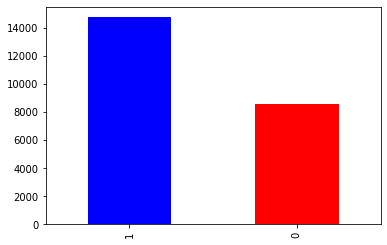

In [42]:
pd.Series(target).value_counts().plot(kind='bar', color=['blue','red'])

Non molto sbilanciata come target... ok.

Prepariamo tutto l'occorrente:

In [46]:
dati = db_final.copy().drop(columns = 'conc1_mean').values
target 

array([1, 1, 1, ..., 0, 0, 0])

In [50]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dati,target, test_size = 0.33, random_state = 42, stratify = target)

Va fatto l'encoding delle variabili discrete

In [55]:
db_final.dtypes

test_cas              object
species               object
conc1_type            object
exposure_type         object
obs_duration_mean    float64
conc1_mean           float64
atom_number          float64
alone_atom_number      int64
bonds_number         float64
doubleBond             int64
tripleBond             int64
ring_number          float64
Mol                  float64
MorganDensity        float64
LogP                 float64
class                 object
tax_order             object
family                object
genus                 object
oh_count              object
dtype: object